import modules

In [179]:
import torch as t
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker


In [108]:
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.latex.preamble"] = "\\usepackage{amssymb}"

In [ ]:
def remove_ticklines(ax):
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

In [904]:
def create_subfig1(subfig):
    grid = t.zeros(7,7)
    grid[2,3] = 1
    grid[4,3] = 1
    ax = subfig.add_axes([-0.15,0.2,0.7,0.7])

    ax.imshow(grid, cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax.grid(color='black', linewidth=1)
    ax = plt.gca()
    ax.set_xticks(np.arange(.5, 7.5, 1))
    ax.set_yticks(np.arange(.5, 7.5, 1))
    remove_ticklines(ax)
    
    plt.text(7,6.3,"$P(x^{(4,6)}_{t+1} = \\blacksquare) = 1 - (1 - \\beta)$")
    plt.text(7,3.3,"$P(x^{(4,4)}_{t+1} = \\blacksquare) = 1 - (1 - \\beta)^2$")
    plt.text(7,0.3,"$P(x^{(4,2)}_{t+1} = \\square) = 0$")

    ax.annotate('',
                xy = (7,0),
                xytext = (3, 2),
                arrowprops = {
                    'arrowstyle': '-', 'ls': 'dotted'
                },
                horizontalalignment = 'center',
                annotation_clip=False)
    ax.annotate('',
                xy = (7,3),
                xytext = (3, 3),
                arrowprops = {
                    'arrowstyle': '-', 'ls': 'dotted'
                },
                horizontalalignment = 'center',
                annotation_clip=False)
    ax.annotate('',
                xy = (7,6),
                xytext = (3, 5),
                arrowprops = {
                    'arrowstyle': '-', 'ls': 'dotted'
                },
                horizontalalignment = 'center',
                annotation_clip=False)
    ax.set_title("$x_t$")
    return subfig

In [981]:
def create_subfig2(subfig):
    training_data = t.load("./data/training_set.pt")
    print(training_data.shape)

    ax1 = subfig.add_axes([0.07, 0.2, 0.18, 0.2])
    remove_ticklines(ax1)
    ax1.text(0.09,0.4,"$f(X,\\beta)$")
    ax1.annotate('',
        xy = (0.5,1),
        xytext = (0.5, 2.8),
        arrowprops = {
            'arrowstyle': '-|>',
            'color': "black"
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )
    ax1.annotate('$\\beta$',
        xy = (0,0.5),
        xytext = (-0.5, 0.4),
        arrowprops = {
            'arrowstyle': '-|>',
            'color': "black"
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )


    ax2 = subfig.add_axes([0.0, 0.84, 0.2, 0.2])
    remove_ticklines(ax2)
    ax2.text(15., -8.5, "$X_t$")
    ax3 = subfig.add_axes([0.05, 0.76, 0.2, 0.2])
    remove_ticklines(ax3)
    ax4 = subfig.add_axes([0.10, 0.68, 0.2, 0.2])
    remove_ticklines(ax4)

    ax2.imshow(training_data[200][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax3.imshow(training_data[400][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax4.imshow(training_data[500][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

    ax5 = subfig.add_axes([0.32, 0.84, 0.2, 0.2])
    remove_ticklines(ax5)
    ax5.text(15., -8.5, "$X_{t+1}$")
    ax6 = subfig.add_axes([0.37, 0.76, 0.2, 0.2])
    remove_ticklines(ax6)
    ax7 = subfig.add_axes([0.42, 0.68, 0.2, 0.2])
    remove_ticklines(ax7)

    ax5.imshow(training_data[200][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax6.imshow(training_data[400][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax7.imshow(training_data[500][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

    ax8 = subfig.add_axes([0.32, 0.22, 0.2, 0.2])
    remove_ticklines(ax8)
    ax8.text(15., -8.5, "$\hat{X}_{t+1}$")
    ax9 = subfig.add_axes([0.37, 0.16, 0.2, 0.2])
    remove_ticklines(ax9)
    ax10 = subfig.add_axes([0.42, 0.08, 0.2, 0.2])
    remove_ticklines(ax10)

    ax8.imshow(training_data[200][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax9.imshow(training_data[300][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    ax10.imshow(training_data[500][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

    ax4.annotate('',
        xy = (125,10.),
        xytext = (64., 10),
        arrowprops = {
            'arrowstyle': '-|>',
            'color': "black"
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )
    ax1.annotate('',
        xy = (1.65,0.5),
        xytext = (1,0.5),
        arrowprops = {
            'arrowstyle': '-|>',
            'color': "black"
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )

    ax10 = subfig.add_axes([0.52, 0.48, 0.52, 0.14])
    remove_ticklines(ax10)
    ax10.text(0.02,0.35,"$\mathcal{L}(\\beta) = MSE(\hat{X}_{t+1}, X_{t+1})$")

    ax10.annotate('',
        xy = (0.12,-1.29),
        xytext = (0.5,0.),
        arrowprops = {
            'arrowstyle': '<|-',
            'color': "black",
            'connectionstyle': "angle",
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )

    ax10.annotate('',
        xy = (0.12,2.61),
        xytext = (0.5,1),
        arrowprops = {
            'arrowstyle': '<|-',
            'color': "black",
            'connectionstyle': "angle",
        },
        horizontalalignment = 'center',
        annotation_clip=False
    )
    return subfig

In [1012]:
def create_subfig3(subfig):
    num_datapoints = 2000
    dist_hist = np.load("./data/sample_based/dist_multibeta_mean0.5_sig0.1.npy")
    beta_hist = np.load("./data/sample_based/betas_multibeta_mean0.5_sig0.1.npy")

    axs = subfig.subplots()
    axs.set_xlabel("gradient steps")

    color = 'darkblue'
    axs.plot(np.arange(num_datapoints), np.array(beta_hist[:num_datapoints]), color=color)
    axs.set_ylabel("$\\beta$", color=color)
    axs.set_yscale("linear")
    axs.minorticks_off()
    axs.tick_params(axis='y', labelcolor=color)

    color = 'r'
    axs2 = axs.twinx()
    axs2.set_ylim((0, 1.2e4))
    axs2.set_ylabel("$\mathcal{L}(\\beta|X)$", color=color)
    axs2.plot(np.arange(num_datapoints), np.array(dist_hist[:num_datapoints]), color=color)
    axs2.tick_params(axis='y', labelcolor=color)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    axs2.yaxis.set_major_formatter(formatter) 

In [1013]:
def create_subfig4(subfig):
    num_datapoints = 2000
    likelihood_hist = np.load("./data/likelihood_based/neg_log_l_multibeta_mean0.5_sig0.1.npy")
    beta_hist = np.load("./data/likelihood_based/betas_multibeta_mean0.5_sig0.1.npy")

    axs = subfig.subplots()
    axs.set_xlabel("gradient steps")

    color = 'darkblue'
    axs.plot(np.arange(num_datapoints), np.array(beta_hist[:num_datapoints]), color=color)
    axs.set_ylabel("$\\beta$", color=color)
    axs.set_yscale("linear")
    axs.minorticks_off()
    axs.tick_params(axis='y', labelcolor=color)
    
    color = 'r'
    axs2 = axs.twinx()
    axs2.set_ylim((0, 1.2e4))
    axs2.set_ylabel("$ - \log P(X_{t+1}|X_t, \\beta)$", color=color)
    axs2.plot(np.arange(num_datapoints), np.array(likelihood_hist[:num_datapoints]), color=color)
    axs2.tick_params(axis='y', labelcolor=color)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,0)) 
    axs2.yaxis.set_major_formatter(formatter) 

# Putting everything together

['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_axes_internal', '_agg_filter', '_align_label_groups', '_alpha', '_animated', '_axobservers', '_axstack', '_callbacks', '_clipon', '_clippath', '_cm_set', '_default_contains', '_gci', '_get_clipping_extent_bbox', '_get_draw_artists', '_gid', '_gridspecs', '_in_layout', '_label', '_localaxes', '_mouseover', '_normalize_grid_string', '_parent', '_path_effects', '_picker', '_process_projection_requirements', '_rasterized', '_redo_transform_rel_fig', '_remove_method', '_set_alpha_for_array', '_set_artist_props', '_set_gc_clip', '_sketch', '_snap', '_stale', '_sticky_edges', '_subplotspec', '_suplab

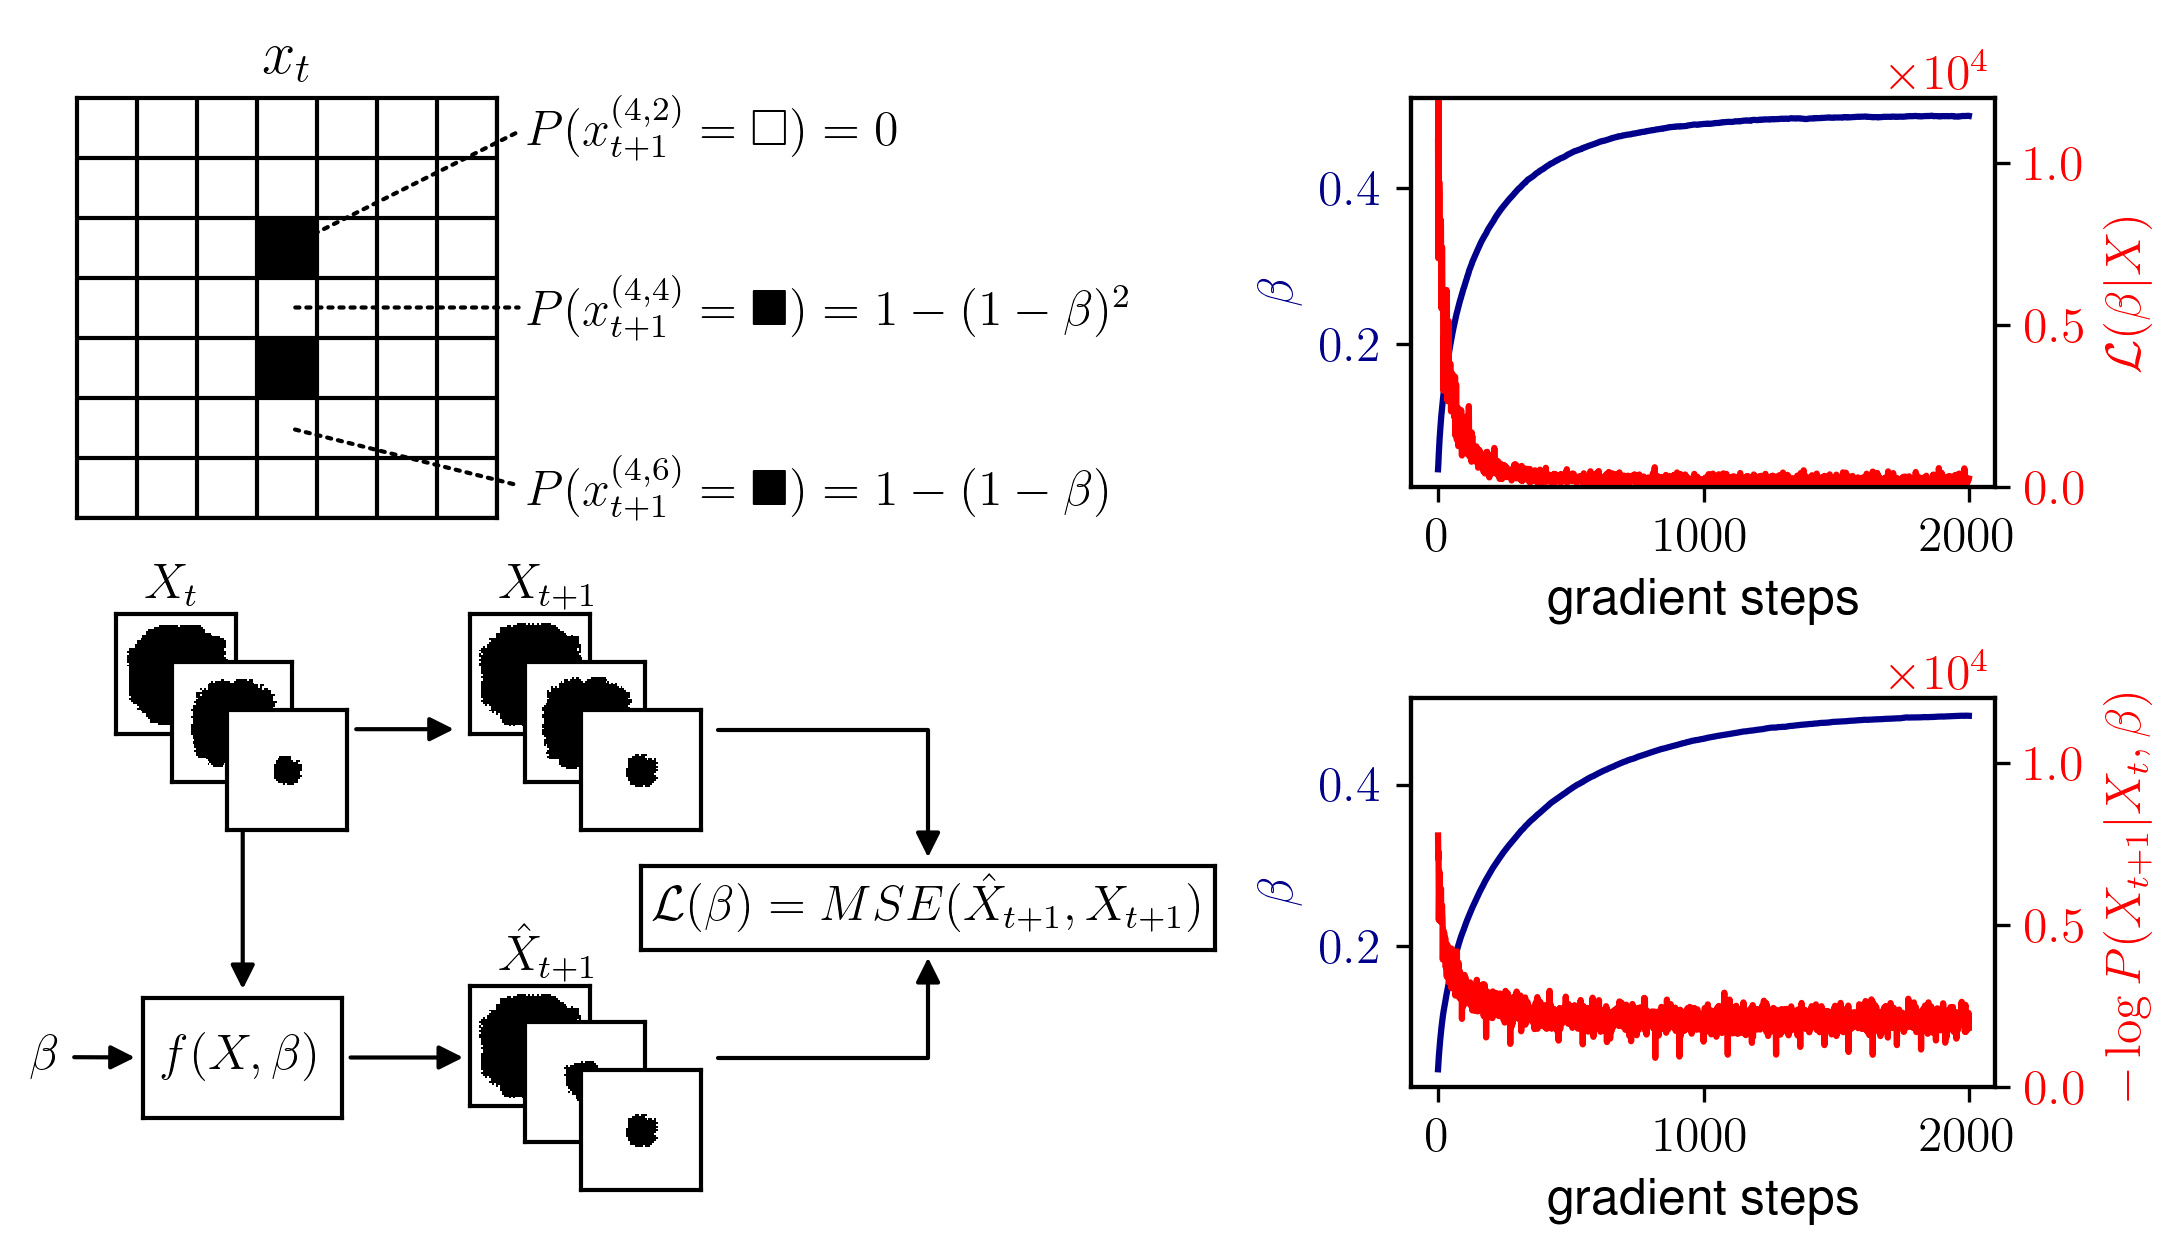

In [1014]:
fig = plt.figure(layout='constrained', figsize=(7,4), dpi=300)
subfigs = fig.subfigures(2, 2, wspace=0.07, hspace=0., width_ratios=[1.2,1])

print(dir(subfigs[1,0]))

create_subfig1(subfigs[0,0])
create_subfig2(subfigs[1,0])
create_subfig3(subfigs[0,1])
create_subfig4(subfigs[1,1])